In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error, balanced_accuracy_score, confusion_matrix
import pymongo

mongohost = "192.168.0.246"
mongoport = 15213
collection = 'MLresults_wideGamma'

# instantiate the mongo client
client = pymongo.MongoClient(mongohost, mongoport)
# get handle to database
db = client.ferret
plt.rcParams['svg.fonttype'] = 'none'

## count matrix

In [22]:
subj = ['14-18','16-18','13-18','15-18']
states = [2,3,3,3]
optimalFeats = [[5,6], [2,3,5],[3,4,6,9],[2,3,4]]
optimalML = ["Nearest Neighbors", "Linear SVM", "Nearest Neighbors", "Linear SVM"]
location = ['S2','S3','S3','S1S1']

resultDict = {}
for isub, iFeat, iClf, iLoc, iNumStates in zip(subj, optimalFeats, optimalML, location, states):
    asd = db[collection].find({"subject":isub,
                "classifier": iClf,
                "feats":iFeat,
                "locs": iLoc})
    
    resultDict[isub] = np.reshape(np.array(asd[0]['confMat']),(iNumStates,iNumStates),None)
    
print resultDict

{'16-18': array([[70.,  0.,  0.],
       [ 1., 56., 13.],
       [ 0., 10., 60.]]), '15-18': array([[51.,  8.,  1.],
       [11., 44.,  5.],
       [ 0.,  1., 59.]]), '14-18': array([[241.,  59.],
       [ 51., 249.]]), '13-18': array([[50., 10.,  0.],
       [11., 45.,  4.],
       [ 0., 11., 49.]])}


In [23]:
# count14 = np.array([[1152.,  348.],[ 207., 1293.]])
# count16 = np.array([[607.,  91.,   2.],[ 47., 653.,   0.],[100., 102., 498.]])
# count13 = np.round(np.array([[600.,   0.,   0.],[  0., 332., 268.],[  0.,  44., 556.]])/600*700)
# count15 = np.round(np.array([[459., 110.,  31.],[ 89., 412.,  99.],[  0.,  28., 572.]])/600*700)
# count29 = np.array([[964., 536.],[508., 992.]])

count14 = resultDict['14-18']
count16 = resultDict['16-18']
count13 = np.round(resultDict['13-18']/600*700)
count15 = np.round(resultDict['15-18']/600*700)

# print np.sum(count15,1)

## accuracies per subject

In [24]:
trueLabels = []
y_pred = []
for countArray, subj in zip([count16, count13, count15], ['16','13','15']):
    print 'subject '+ subj 
    subj_trueLabels = [1]*int(sum(countArray[0,:]))+[2]*int(sum(countArray[1,:]))+[3]*int(sum(countArray[2,:]))
    subj_predLabels = ([1]*int(countArray[0,0])+[2]*int(countArray[0,1])+ [3]*int(countArray[0,2])
              +[1]*int(countArray[1,0])+[2]*int(countArray[1,1])+ [3]*int(countArray[1,2])
              +[1]*int(countArray[2,0])+[2]*int(countArray[2,1])+ [3]*int(countArray[2,2]))
    subj_accuracy = accuracy_score(subj_trueLabels, subj_predLabels)*100
    
    classError_tmp = sum([ x==y for (x,y) in zip(subj_trueLabels, subj_predLabels)]) / float(len(subj_trueLabels))
#     classError_tmp = mean_absolute_error(subj_trueLabels, subj_predLabels)
    
    n = len(subj_trueLabels)
    CI_tmp = 1.96 * np.sqrt( (classError_tmp * (1 - classError_tmp)) / n)
    
    print 'Accuracy: %0.4f CI = %0.04f +/- %0.04f' %(subj_accuracy, classError_tmp, CI_tmp)
    
    trueLabels = trueLabels+subj_trueLabels
    y_pred = y_pred+subj_predLabels


subject 16
Accuracy: 88.5714 CI = 0.8857 +/- 0.0430
subject 13
Accuracy: 79.5238 CI = 0.7952 +/- 0.0546
subject 15
Accuracy: 85.7143 CI = 0.8571 +/- 0.0473


## metrics for 3 states

    ### precision = positive predictive value
    ### recall = sensitivity
    ### F1 score = precision * recall /(precision + recall)

In [25]:
confMat = confusion_matrix(trueLabels, y_pred)
print confMat 

[[188  21   1]
 [ 27 159  24]
 [  0  24 186]]


In [26]:
classError_3 = mean_absolute_error(trueLabels, y_pred)
print classError_3

n = len(trueLabels)
CI_3 = 1.96 * np.sqrt( (classError_3 * (1 - classError_3)) / n)
print CI_3

0.15555555555555556
0.0283018028382601


In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(trueLabels, y_pred, target_names=['base', 'early', 'late']))
print( 'accuracy', accuracy_score(trueLabels, y_pred))

# specificity
# base
tn_base = float(np.sum(confMat[[1,2],[1,2]]))
fp_base = np.sum(confMat[[1,2],0])
specBase = tn_base/(tn_base+fp_base)
print ('base spec', specBase)

# early
tn_early = float(np.sum(confMat[[0,2],[0,2]]))
fp_early = np.sum(confMat[[0,2],1])
specEarly = tn_early/(tn_early+fp_early)
print ('early spec', specEarly)

# late
tn_late = float(np.sum(confMat[[0,1],[0,1]]))
fp_late = np.sum(confMat[[0,1],2])
specLate = tn_late/(tn_late+fp_late)
print ('late spec', specLate)

              precision    recall  f1-score   support

        base       0.87      0.90      0.88       210
       early       0.78      0.76      0.77       210
        late       0.88      0.89      0.88       210

   micro avg       0.85      0.85      0.85       630
   macro avg       0.85      0.85      0.85       630
weighted avg       0.85      0.85      0.85       630

('accuracy', 0.846031746031746)
('base spec', 0.9274193548387096)
('early spec', 0.8926014319809069)
('late spec', 0.9327956989247311)


## TNR and TPR

In [28]:
fn_late = float(confMat[2,0]+confMat[2,1])
tp_late = confMat[2,2]
false_negative_late = fn_late/(fn_late+tp_late)
print 'FNR: %f' %false_negative_late

fp_late = np.sum(confMat[[0,1],2])
tn_late = float(confMat[0,0]+confMat[1,1])
false_positive_late = fp_late/(fp_late+tn_late)
print 'FPR: %f' %false_positive_late

FNR: 0.114286
FPR: 0.067204


## metrics for 2 states
    ### in binary classification, recall of the positive class is also known as “sensitivity”; 
    ### recall of the negative class is “specificity”

In [29]:
true14 = [1]*int(sum(count14[0,:]))+[2]*int(sum(count14[1,:]))
pred14 = ([1]*int(count14[0,0])+[2]*int(count14[0,1])
          +[1]*int(count14[1,0])+[2]*int(count14[1,1]))

confMat14 = confusion_matrix(true14, pred14)
print confMat14

[[241  59]
 [ 51 249]]


In [30]:
classError_2 = sum([ x==y for (x,y) in zip(true14, pred14)]) / float(len(true14))

n = len(trueLabels)
CI_2 = 1.96 * np.sqrt( (classError_2 * (1 - classError_2)) / n)

accuracy14 = accuracy_score(true14, pred14)*100

print 'Accuracy: %0.4f CI = %0.04f +/- %0.04f' %(accuracy14, classError_2, CI_2)

Accuracy: 81.6667 CI = 0.8167 +/- 0.0302


In [31]:
print(classification_report(true14, pred14, target_names=['early', 'late']))

# specificity
# base
tn_base14 = float(np.sum(confMat14[1,1]))
fp_base14 = np.sum(confMat14[1,0])
specBase14 = tn_base14/(tn_base14+fp_base14)
print ('base spec', specBase14)

# early
tn_early14 = float(np.sum(confMat14[0,0]))
fp_early14 = np.sum(confMat14[0,1])
specEarly14 = tn_early14/(tn_early14+fp_early14)
print ('early spec', specEarly14)


              precision    recall  f1-score   support

       early       0.83      0.80      0.81       300
        late       0.81      0.83      0.82       300

   micro avg       0.82      0.82      0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

('base spec', 0.83)
('early spec', 0.8033333333333333)


### TNR and TPR

In [32]:
fn_late = float(confMat14[1,0])
tp_late = confMat14[1,1]
false_negative_late14 = fn_late/(fn_late+tp_late)
print 'FNR: %f' % false_negative_late14

fp_late = float(confMat14[0,1])
tn_late = confMat14[0,0]
false_positive_late14 = fp_late/(fp_late+tn_late)
print 'FPR: %f' % false_positive_late14

FNR: 0.170000
FPR: 0.196667


## combined confusion matrix

Text(452.236,0.5,'true labels')

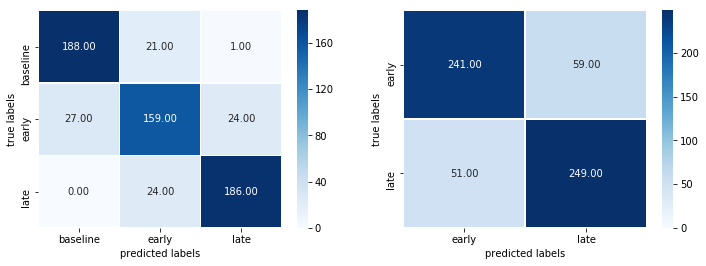

In [20]:
totalCounts = coun[100, 0.001, u'rbf'][100, u'linear']optimal_combined_params15-18:Linear SVMcombined_consistency1.00.80.60.40.20.0label[4, 5][1, 2, 5, 6][3, 4, 5, 6, 9][3, 4, 5, 9][1, 2, 3, 5, 6][3, 5, 6][1, 5, 6, 9][2, 5, 9][1, 2, 5, 6, 9][2, 3, 4][1, 0.001, u'rbf'][1000, 0.001, u'rbf'][10, u'linear']optimal_combined_params13-18:Linear SVMcombined_consistency1.00.80.60.40.20.0label[1][1, 5][4, 5][1, 3, 5][5][2, 3, 4][1, 3, 4, 5, 9][1, 2, 5, 6][2, 3, 5, 6, 9][2, 4, 5, 9][1000, 0.001, u'rbf']optimal_combined_params16-18:Linear SVMcombined_consistency1.00.80.60.40.20.0label[2, 3, 5, 9][2, 3, 6, 9][1, 2, 3, 6, 9][4, 5][3, 5, 6, 9][3, 4, 5, 6][2, 3, 4, 5, 6][1, 5, 6, 9][1, 2, 3, 4, 5, 6][2, 3, 5][1, 0.001, u'rbf'][10, 0.001, u'rbf'][1000, 0.001, u'rbf']optimal_combined_params14-18:Linear SVMcombined_consistency1.00.80.60.40.20.0label[9][4][4, 9][2, 4, 5, 9][2, 3, 6, 9][2, 3, 6][2, 3, 4, 6][2, 3, 4, 6, 9][1, 2, 4, 5][6]1noptimal_params15-18:Nearest Neighborsneighbor_consistency1.00.80.60.40.20.0label[1, 4, 6][2, 3, 4, 6][1, 6, 9][1, 3, 4, 5, 6, 9][4, 6, 9][1, 2, 3, 4, 6][1, 3, 4, 5, 6][1, 4, 6, 9][2, 6, 9][2, 3, 4, 5, 6]1noptimal_params13-18:Nearest Neighborsneighbor_consistency1.00.80.60.40.20.0label[1, 2, 4, 5, 6, 9][1, 2, 3, 6, 9][2, 5, 6, 9][6, 9][1, 2, 4, 6, 9][2, 5, 6][3, 6, 9][2, 4, 6, 9][4, 6, 9][3, 4, 6, 9]1noptimal_params16-18:Nearest Neighborsneighbor_consistency1.00.80.60.40.20.0label[1, 2, 5, 9][1, 2, 3, 4, 5, 6][2, 5, 6, 9][5, 6][1, 2, 3, 6, 9][2, 4, 6][1, 3, 6][1, 2, 3, 5][1, 4, 5, 6][3, 5, 6]1noptimal_params14-18:Nearest Neighborsneighbor_consistency1.00.80.60.40.20.0label[2, 4, 5, 9][4, 5][3, 5, 6, 9][4, 5, 6][2, 3, 5, 6, 9][2, 3, 5, 6][2, 5, 6][2, 3, 4, 5, 6][5, 6][2, 4, 5, 6, 9]t16+count13+count15
f,ax = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(totalCounts, cmap='Blues' ,annot=True,fmt='.02f',linewidths=.5,xticklabels=['baseline','early','late'], yticklabels=['baseline','early','late'],vmax=np.max(totalCounts),vmin=0, ax=ax[0])
sns.heatmap(count14, cmap='Blues' ,annot=True,fmt='.02f',linewidths=.5,xticklabels=['early','late'], yticklabels=['early','late'],vmax=np.max(count14),vmin=0,ax=ax[1])
ax[0].set_xlabel('predicted labels')
ax[0].set_ylabel('true labels')

ax[1].set_xlabel('predicted labels')
ax[1].set_ylabel('true labels')